<a href="https://colab.research.google.com/github/easyhardhoon/machine_learning/blob/master/ML13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#오버피팅을 억제하는 방법

#1. 가중치 감소

오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많다

그래서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법이 가중치 감소이다

**가중치가 W였으면 가중치 감소를 통해 1/2ㅅW^2로 바꾼다**. 

**이 값을 손실함수에 더한다.**

가중치가 너무 크면 손실 함수의 값이 너무 확 줄어드니 그걸 방지하기 위한 것이라고 생각

ㅅ(람다) : 정규화의 세기를 조절하는 하이퍼파라미터

L2 norm : 각 원소의 제곱들을 더한 값

#즉

가중치 감소는 모든 가중치 각각의 손실 함수에 1/2ㅅW^2를 더한다

가중치의 기울기를 구하는 계산에서, 오차역전법의 결과에 (이 정규화 항을 미분한) **ㅅW**을 더한다

아래의 가중치 감소를 적용한 코드의 그래프를 보면,

오버피팅이 억제된 모습을 볼 수 있다. + 훈련 데이터에 대한 정확도가 100%에 도달하지 못하였다



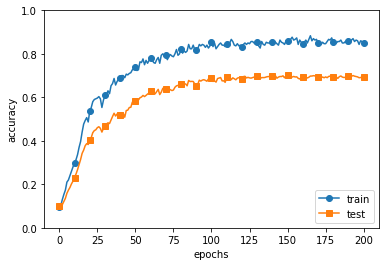

In [ ]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from multi_layer_net import MultiLayerNet
from optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        #print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#2. 드롭아웃

가중치 감소는 간단하게 구현할 수 있고 어느 정도 지나친 학습을 억제할 수 있지만

신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어렵다.

이럴때는 드롭아웃이라는 기법을 이용한다.

드롭아웃은, 뉴런을 임의로 삭제하며 학습하는 방법이다.

훈련떄 은닉층의 뉴런을 무작위로 골라 삭제한다. 

훈련때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택하고, 시험 때는 모든 뉴런에 신호를 전달한다. 

단, 시험때는 각 뉴련의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력한다

(사실 곱하지 않아도 좋다, 실제 딥러닝 프레임워크들도 비율을 곱하지 않음)



In [ ]:
import numpy as np
class Dropout:
  def __init__(self,dropout_ratio = 0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None
  def forward(self,x,train_flg=True):
    if train_flg:
      self.mask = np.random.rand(*x.shape) > self.dropout_ratio #ratio보다 큰 값만 true(1), 아니면 false(0)
      #갑자기 *가 나와서 당황할 수 있겠지만
      #x.shape의 형식이 튜플이기 때문에 구분하기 위하여 썼다고 생각.
      #즉 x.shape가 (2.3)이면 np.random.rand(2,3)과 같은 말이라고 할 수 있다.
      return x * self.mask #결론적으로 ratio기준 큰 값들만 올바르게 흐르고 나머지는 막아버린다는 느낌 구현 완료
    else:
      return x * (1.0 * self.dropout_ratio)
  def backward(self,dout):
    return dout * self.mask #순전파때 흘렀던건 역전파떄도 흐르게 한다. RELU 와 동일하다.

train loss:2.3030886320811566
train loss:2.313986877407042
train loss:2.30606893076447
train loss:2.3009966691834
train loss:2.295038746575266
train loss:2.2969212260932466
train loss:2.30133550858684
train loss:2.299074783370869
train loss:2.2866692813120544
train loss:2.2948186066597778
train loss:2.3139748675176643
train loss:2.299244586410641
train loss:2.2946170315751426
train loss:2.300189328083236
train loss:2.297163349955228
train loss:2.2885853050506113
train loss:2.294458989568734
train loss:2.297352174089609
train loss:2.2928088390232197
train loss:2.2908185572208386
train loss:2.294403799298263
train loss:2.2971640530776583
train loss:2.2882670026050227
train loss:2.3025196069252547
train loss:2.2982791971014
train loss:2.2877057267654552
train loss:2.291462331936229
train loss:2.2918112204760375
train loss:2.289714964675606
train loss:2.3008443936625955
train loss:2.2839963575718447
train loss:2.298601455495009
train loss:2.293311690283478
train loss:2.278609004580513
trai

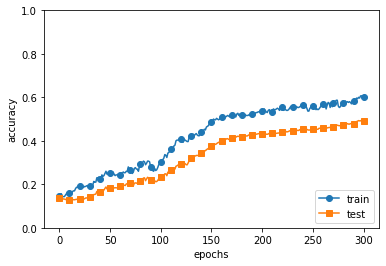

In [10]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from multi_layer_net_extend import MultiLayerNetExtend
from trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784,
                              hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout,
                              dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
# epoch:301, train acc:0.73, test acc:0.6315

#그래프에서 보면

++ 아무 조치도 취하지 않은 테스트 그래프는 가중치 감소의 그래프의 두 간격보다 훨씬 벌어져 있습니다.


훈련데이터와 시험 데이터에 대한 정확도 차이가 현저히 줄었다.

또 훈련데이터에 대한 정확도가 100%에 도달하지도 않게 되었다.

+ 이 뜻은 , 안좋은 의미가 아니라 그만큼 표현력이 높아졌다고 해석 가능

+ **드롭아웃은 앙상블 학습과 같은 효과를 하나의 네트워크로 구현했**다고 해석 가능


-------> ex) 드롭아웃으로 학습 때 뉴런을 무작위로 삭제하는 행위를 매번 다른 모델을 학습시키는 것으로 해석 가능

-------> ex) (안하지만) 추론(시험)때 뉴런의 출력에 삭제한 비율을 곱하는 방식은 앙상블  학습에서 여러 모델의 평균을 내는 것으로 해석 가능

+ 앙상블 학습 : 개별적으로  학습시킨 여러 모델의 출력을 평균 내어 추론하는 방식


드롭아웃이나 가중치 감소나 일종의 layer 계층으로 활동합니다



#적절한 하이퍼파라미터 값 찾기

하이퍼 파라미터를 다양한 값으로 설정하고 검증할때, 시험 데이터를 사용해서는 안된다. 나중에 테스트를 그걸로 할건데 그걸로 하면 어캄. 

그래서 따로 데이터가 필요한데, 이 데이터를 검증 데이터라고 한다.

**훈련 데이터 : 매개변수 학습**

**검증 데이터 : 하이퍼파라미터 성능 평가**

**시험 데이터 : 신경망의 범용 성능 평가**

#하이퍼 파라미터 최적화

**핵심 : 하이퍼 파라미터의 최적 값이 존재하는 범위를 조금씩 줄여나가기**

참고로 그리드 서치같은 규칙적인 탐색보다는 무작위 탐색이 좋은 결과를 낸다고  알려져있다

하이퍼 파라미터의 최적화의 딥러닝 학습에는 오랜시간이 걸림(거의 몇 주 이상) .

그래서 학습을 위한 에폭을 작게 하여 1회 평가에 걸리는 시간을 단축하는 것이 효과적. 

또한 하이퍼 파라미터의 범위는 대략적으로 지정하는 것이 효과적임. 

**대략적**으로 지정하고, 그 범위에서 **무작위**로 하이퍼파라미터의 값을 골라내고 그 값으로 **정확도를 평가하고** 

이러한 작업을 **여러번 반복**하여 **하이퍼 파라미터의 최적값의 범위를 좁혀나가**는 것이다

이는 <실용적인 방법> 이고, 세련된 기법으로는 <베이즈 최적화>가 있긴 하다




#하이퍼 파라미터 최적화 구현 (코드 생략)

MNIST 데이터셋에서, 학습률과 가중치감소계수 이 2개의 하이퍼 파라미터를 탐색하는 문제

앞서 말한대로 하이퍼 파라미터의 검증은 예를 들어 0.001~1000같은 로그 스케일 범위에서 무작위로 추출해 수행한다.

이 예에서는 가중치 감소 계수를 10^-8 ~ 10^-4, 학습률을 10^-6 ~ 10^-2 범위에서 시작한다. 

In [4]:
import numpy as np
weight_key = 10 ** np.random.uniform(-8,-4)
lr  =  10**np.random.uniform(-6,-2)
#np.random.uniform(low,high,size) : 균등분포로부터 low~high범위내 무작위 size번 추출. 여기서는 default로 1개가 들어간 것으로 보임  

#이처럼

무작위로 추출한 값을 사용하여 학습을 수행. 이러한 작업을 여러차례 학습 반복하여 신경망에 좋을 것 같은 값이 어디에 존재하는지 관찰

#결과를 보면

당연하게도 어떠한 값은 정확도가 매우 높은 반면 어떠한 값들은 학습이 잘 되지 않는다.

학습이 잘 진행 때의 학습률은 0.001~0.01, 

가중치 감소 계수는 10^-8~ 10^-6 정도라는 것을 알 수 있다.

이처럼 잘될 것 같은 값의 범위를 좁혀나간다. 이후 그 축소된 범위로 똑같은 작업을 반복한다.

이렇게 적절한 값이 위치한 범위를 좁혀가다가 특정 단계에서 최종 하이퍼파라미터 값을 하나 선택한다.